

# **Predicción con SVD++**


# Índice

>[Índice](#scrollTo=2j02H66f87eV)

>[Descargando la información](#scrollTo=9qKTQ2V5VKSX)

>[Preparar entorno](#scrollTo=P3K5VPZoGSYX)

>[UserKNN](#scrollTo=2e0ZeZXzMhU3)

>>[Generar una lista de recomendaciones para un usuario](#scrollTo=dIVXNsQ8CCJV)

>>>[Evaluar en base a error de prediccion (RMSE y MAE)](#scrollTo=g55SDLmqCpUo)



# Descargando la información


In [1]:
import pandas as pd

train_file = pd.read_csv('../data/training_set.csv', sep=',', header=0)
train_file = train_file[['userID', 'itemID', 'rating']]
train_file.head()

,userID,itemID,rating
0,401,32780,3.0
1,7548,21688,3.5
2,7663,1521,4.0
3,1357,3824,3.5
4,1361,727,4.5


In [2]:
validation_file = pd.read_csv('../data/validation_set.csv', sep=',', header=0)
validation_file = validation_file[['userID', 'itemID', 'rating']]
validation_file.head()

,userID,itemID,rating
0,1040,4920,4.0
1,1306,7348,4.0
2,932,4073,4.0
3,6735,16074,4.5
4,197,39299,4.0


## Preparando entorno

In [3]:
pip install scikit-surprise

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import surprise
import numpy as np
import os
import psutil
import pandas as pd
import scipy.sparse as sparse
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
import seaborn as sns
import time
import matplotlib.pyplot as plt

## SVD ++


In [5]:
user_items = {}
itemset = set()

for row in train_file.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

# Recordar que se tiene set con los itemID ordenados de los items
itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [6]:
from surprise.model_selection import PredefinedKFold
reader = surprise.Reader(line_format='user item rating', sep=',', rating_scale=(1,5))
train_data = surprise.Dataset.load_from_df(train_file[['userID', 'itemID', 'rating']], reader)
testset = list(zip(validation_file['userID'], validation_file['itemID'], validation_file['rating']))


In [7]:
from surprise import SVDpp
trainset = train_data.build_full_trainset()

In [8]:
# Definicion de objeto svd++
algorithm = SVDpp()
# Entrenamiento del modelo
algorithm.fit(trainset)

In [9]:
# Hacer predicciones sobre el conjunto de validación
predictions = algorithm.test(testset)

In [10]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.5919
MAE:  0.4434


0.4434358738677646

## Análisis de sensibilidad 

## Métricas de desempeño

In [21]:
factor_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]
mae_values = [] 
rmse_values = []

for f in factor_values:
  algorithm = SVDpp(n_factors=f)
  algorithm.fit(trainset)
  predictions = algorithm.test(testset)
  mae = accuracy.mae(predictions)
  rmse = accuracy.rmse(predictions)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

MAE:  0.4463
RMSE: 0.5960
MAE:  0.4506
RMSE: 0.6015
MAE:  0.4530
RMSE: 0.6023
MAE:  0.4568
RMSE: 0.6073
MAE:  0.4586
RMSE: 0.6097
MAE:  0.4631
RMSE: 0.6157
MAE:  0.4645
RMSE: 0.6169
MAE:  0.4687
RMSE: 0.6216
MAE:  0.4645
RMSE: 0.6163
MAE:  0.4705
RMSE: 0.6259
MAE:  0.4682
RMSE: 0.6261
[0.446317848740298, 0.4506133026183296, 0.45297276526231595, 0.4567766411200459, 0.4586205257581713, 0.46307120377600397, 0.46445569748406773, 0.46866918913188715, 0.46453599238612897, 0.4705130053464148, 0.46821231376694006]
[0.5960437588508487, 0.6014654200669605, 0.6022770735559267, 0.6073011754499881, 0.6097162534237517, 0.615655981605155, 0.6168648699178249, 0.621614202337608, 0.6163013522626075, 0.6259377238143274, 0.6260779726797854]


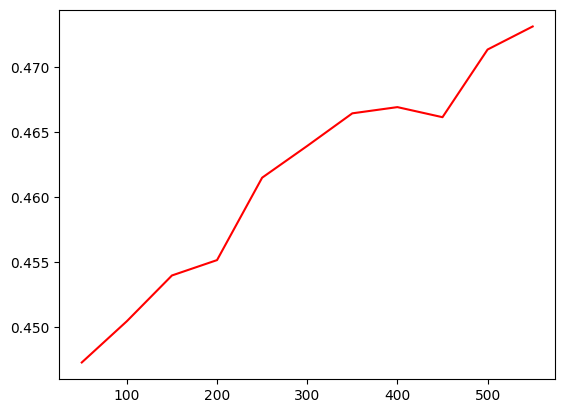

In [72]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

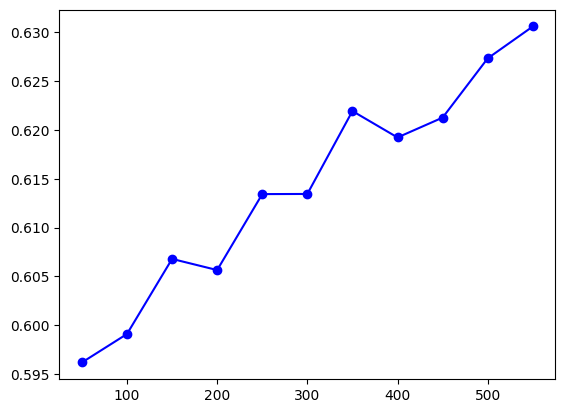

In [73]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

In [8]:
learning_rates = [0.001, 0.004, 0.007, 0.01, 0.013]
regularizations = [0.005, 0.01, 0.015, 0.02, 0.025]
factor_values = [50, 100, 150, 200, 250]
maxiter_values = [100, 150, 200, 250, 300] 
lr_res = []
lamb_res = []
factor_res = []
rmse_res = []
maxiter_res = []

for fact in factor_values:
  for reg in regularizations:
    for lr in learning_rates:
        algorithm = SVDpp(n_factors=fact, n_epochs=100, lr_all=lr, reg_all=reg)
        algorithm.fit(trainset)
        predictions = algorithm.test(testset)
        rmse = accuracy.rmse(predictions)
        
        lr_res.append(lr)
        lamb_res.append(reg)
        factor_res.append(fact)
        rmse_res.append(rmse)
        #maxiter_res.append(maxiter)

RMSE: 0.6010
RMSE: 0.6514
RMSE: 0.6524
RMSE: 0.6536
RMSE: 0.6513
RMSE: 0.5940
RMSE: 0.6323
RMSE: 0.6387
RMSE: 0.6345
RMSE: 0.6307
RMSE: 0.5931
RMSE: 0.6204
RMSE: 0.6283
RMSE: 0.6335
RMSE: 0.6254
RMSE: 0.5932
RMSE: 0.6159
RMSE: 0.6252
RMSE: 0.6259
RMSE: 0.6229
RMSE: 0.5919
RMSE: 0.6122
RMSE: 0.6155
RMSE: 0.6204
RMSE: 0.6177
RMSE: 0.6096
RMSE: 0.6376
RMSE: 0.6356
RMSE: 0.6324
RMSE: 0.6289
RMSE: 0.5997
RMSE: 0.6323
RMSE: 0.6254
RMSE: 0.6198
RMSE: 0.6149
RMSE: 0.6003
RMSE: 0.6208
RMSE: 0.6173
RMSE: 0.6125
RMSE: 0.6115
RMSE: 0.5995
RMSE: 0.6117
RMSE: 0.6110
RMSE: 0.6094
RMSE: 0.6111
RMSE: 0.5974
RMSE: 0.6097
RMSE: 0.6098
RMSE: 0.6093
RMSE: 0.6097
RMSE: 0.6160
RMSE: 0.6342
RMSE: 0.6341
RMSE: 0.6252
RMSE: 0.6253
RMSE: 0.6100
RMSE: 0.6259
RMSE: 0.6231
RMSE: 0.6164
RMSE: 0.6165
RMSE: 0.6048
RMSE: 0.6147
RMSE: 0.6141
RMSE: 0.6116
RMSE: 0.6081
RMSE: 0.5997
RMSE: 0.6141
RMSE: 0.6090
RMSE: 0.6052
RMSE: 0.6066
RMSE: 0.5999
RMSE: 0.6052
RMSE: 0.6061
RMSE: 0.6061
RMSE: 0.6061
RMSE: 0.6249
RMSE: 0.6380

KeyboardInterrupt: 

In [9]:
# Encontrar el índice del menor RMSE
min_rmse_index = rmse_res.index(min(rmse_res))

best_combination = {
    'Learning Rate': lr_res[min_rmse_index],
    'Regularization': lamb_res[min_rmse_index],
    'Factors': factor_res[min_rmse_index],
    'RMSE': rmse_res[min_rmse_index]
}

print("Mejor combinación de hiperparámetros:")
print(best_combination)

Mejor combinación de hiperparámetros:
{'Learning Rate': 0.001, 'Regularization': 0.025, 'Factors': 50, 'RMSE': 0.5919121315683699}


In [14]:
start_time = time.time()
mem_info_before = psutil.virtual_memory().used
cpu_usage_before = psutil.cpu_percent(interval=None)

# Definicion de objeto svd++
algorithm = SVDpp()
# Entrenamiento del modelo
algorithm.fit(trainset)

end_time = time.time()
mem_info_after = psutil.virtual_memory().used
memory_used = (mem_info_after - mem_info_before) / (1024 ** 2)
cpu_usage_after = psutil.cpu_percent(interval=None)

print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")
print(f"Memoria utilizada: {memory_used} MB")
print(f"Uso de CPU: {cpu_usage_after - cpu_usage_before}%")

Tiempo de entrenamiento: 1.3296141624450684 segundos
Memoria utilizada: 0.0 MB
Uso de CPU: 6.700000000000001%


## Rating

In [36]:
rating_test = pd.read_csv('../templates/rating_template_fill.csv', sep=';', header=0)
rating_test.head()

,itemID,styleID,Rating,userID
0,39289,14756,NaN,715
1,3939,1417,NaN,4944
2,47695,14879,NaN,4890
3,7348,1199,NaN,5324
4,37403,1199,NaN,5544


In [47]:
# Función para obtener el promedio de ratings de un usuario en caso de que el item no esté en training
def user_average_rating(user_id, train_ratings):
    user_ratings = train_ratings[train_ratings['userID'] == user_id]['rating']
    if len(user_ratings) > 0:
        return round(user_ratings.mean(),4)
    else:
        return round(train_ratings['rating'].mean(),4)

# Lista de ítems en training
training_items = train_file['itemID'].unique()

In [61]:
for index, row in rating_test.iterrows(): 
    user_id = str(int(row.iloc[3]))
    item_id = str(int(row.iloc[0]))
    
    if int(item_id) not in training_items:
      rating = user_average_rating(user_id, train_file)
    else:
        prediccion = algorithm.predict(user_id, item_id)
        rating = prediccion.est
    rating_test.at[index, 'Rating'] = rating


In [62]:
rating_test.head()

,itemID,styleID,Rating,userID
0,39289,14756,3.868971,715
1,3939,1417,3.868971,4944
2,47695,14879,3.868971,4890
3,7348,1199,3.868971,5324
4,37403,1199,3.868971,5544


In [65]:
ruta = os.path.join('../predictions', 'rating_svd.csv')
rating_test.to_csv(ruta, index=False)